**Let us first define the ucb_bandit class.**

In [0]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
class ucb_bandit:

    '''
    Upper Confidence Bound Bandit (with DP)
    
    Inputs 
    ============================================
    k: number of arms (int)
    iters: number of steps (int)
    mu: average rewards for each of the k-arms.
    epsilon: parameter of DP
    type: DP mechanism (e.g., Laplace or Bernoulli)
    '''
    def __init__(self, k, iters, mu, epsilon = 0, type = None):
        # Number of arms
        self.k = k
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 1
        # Step count for each arm
        self.k_n = np.ones(k)
        # Total regret
        self.total_regret = 0
        self.regret = np.zeros(iters)
        # Empirical reward for each arm
        self.k_reward = np.zeros(k)
        # Privacy parameter
        self.epsilon = epsilon
        # Average reward for each arm
        self.mu = np.array(mu)
        # DP type
        self.type = type

    # Naive UCB
    def pull(self):
        # Select action according to UCB Criteria
        a = np.argmax(self.k_reward +  np.sqrt(
                (2*np.log(self.n)) / self.k_n))
            
        reward = np.random.binomial(1,self.mu[a],1)
        optimal_reward = np.random.binomial(1,self.mu[0],1)

        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total
        self.total_regret = self.total_regret + optimal_reward - reward
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.k_n[a]

    # LDP-UCB-B 
    def pull_CTB(self):
        # Select action according to the Criteria
        a = np.argmax(self.k_reward + np.sqrt(
                (2*np.log(self.n)) / self.k_n))
            
        reward = np.random.binomial(1,self.mu[a],1)
        optimal_reward = np.random.binomial(1,self.mu[0],1)

        # Update total
        self.total_regret = self.total_regret + optimal_reward - reward

        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Using Bernoulli mechanism
        mu_converted = (reward*np.exp(self.epsilon)+1-reward )/(1+np.exp(self.epsilon))
        reward_converted = np.random.binomial(1,mu_converted,1)

        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
            reward_converted - self.k_reward[a]) / self.k_n[a]

    # LDP-UCB-L
    def pull_CTL(self):
        # Select action according to the Criteria
        th = 4 * np.log(self.n + 1) # threshold
        k_n_th = [(i,el) for (i,el) in enumerate(self.k_n) if el <= th]
        if len(k_n_th) > 0:
            a = k_n_th[0][0]
        else:
            a = np.argmax(self.k_reward + np.sqrt(
                    (2*np.log(self.n)) / self.k_n) + np.sqrt(
                    (32*np.log(self.n) / (self.epsilon * self.epsilon * self.k_n))))

        reward = np.random.binomial(1,self.mu[a],1)
        optimal_reward = np.random.binomial(1,self.mu[0],1)

        # Update total
        self.total_regret = self.total_regret + optimal_reward - reward

        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Using Laplace mechanism
        
        reward_converted = reward + np.random.laplace(0,1/self.epsilon,1)

        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
            reward_converted - self.k_reward[a]) / self.k_n[a]

    def run(self):
        for i in range(self.iters):
          if self.type == 'Laplace':
            self.pull_CTL()
          elif self.type == 'Bernoulli':
            self.pull_CTB()
          else:
            self.pull()
          self.regret[i] = self.total_regret
            
    def reset(self):

        # Resets results while keeping settings
        self.n = 1
        self.k_n = np.ones(self.k)
        self.total_regret = 0
        self.regret = np.zeros(self.iters)
        self.k_reward = np.zeros(self.k)
        

**Define experiments for comparing different algorithms and epsilon values**

In [0]:
def experiment_with_algorithms(k, mu, epsilon, type_list, iters=100000, episodes=100):
    
    UCB_list = []
    for i in range(len(type_list)):
        UCB_list.append(ucb_bandit(k,iters, mu, epsilon, type_list[i]))

    Regrets_list = []
    for _ in range(len(type_list)):
        Regrets_list.append(np.zeros(iters))
    for j in range(len(type_list)):
        for i in range(episodes): 
            UCB_list[j].reset()
            UCB_list[j].run()
            Regrets_list[j] = Regrets_list[j] + (
                UCB_list[j].regret - Regrets_list[j]) / (i + 1)

    return Regrets_list
    


In [0]:
def experiment_with_epsilon(k, mu, epsilon_list, type, iters=100000, episodes=100):
    UCB_list = []
    for i in range(len(epsilon_list)):
        UCB_list.append(ucb_bandit(k,iters, mu, epsilon_list[i],type))

    Regrets_list = []
    for _ in range(len(epsilon_list)):
        Regrets_list.append(np.zeros(iters))

    for j in range(len(epsilon_list)):
        for i in range(episodes): 
            UCB_list[j].reset()
            UCB_list[j].run()
            Regrets_list[j] = Regrets_list[j] + (
                UCB_list[j].regret - Regrets_list[j]) / (i + 1)

    return Regrets_list

**The Main Funciton.**

First, we compare different algoirthms with a fixed value of epsilon.

(a) $\epsilon = 0.5$, $T=10e4$, $n = 5$, $\Delta = 0.5$

In [0]:
type_list = [None, 'Bernoulli', 'Laplace']
k = 5
mu = [0.9, 0.4, 0.4, 0.4, 0.4]
iters = 100000
episodes = 100

In [0]:
epsilon = 0.5
regrets_algorithms= experiment_with_algorithms(k,mu,epsilon,type_list,
                                                    iters,episodes)

In [0]:
# remember to mount your drive before saving data
#from google.colab import drive
#drive.mount('/content/gdrive')
np.savetxt('/content/gdrive/My Drive/regrets_algorithms_05_k5.csv', regrets_algorithms, delimiter=',')

In [0]:
regrets_algorithms = np.loadtxt('/content/gdrive/My Drive/regrets_algorithms_05_k5.csv', delimiter=',')

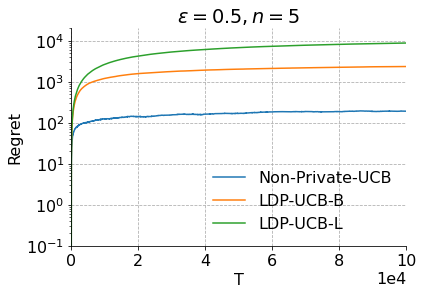

In [81]:
fig = plt.figure()
ax = fig.gca()
for i in range(len(type_list)):
    type = type_list[i] if type_list[i] is not None else 'UCB'
    if type == 'Bernoulli':
        label = 'LDP-UCB-B'
    elif type == 'Laplace':
        label = 'LDP-UCB-L'
    else:
        label = 'Non-Private-UCB'
    ax.plot(regrets_algorithms[i], label=label )

plt.yscale('log')
plt.xlabel("T")
plt.ylabel("Regret")
plt.title("$\epsilon = 0.5, n = 5$")
plt.grid('True',linestyle = '--')
plt.axis([0, 100000, 0.1, 20000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams.update({'font.size': 16})
plt.ticklabel_format(style='sci', axis='x',scilimits=(4,4))
ax.legend(loc='lower right', frameon=False)
plt.savefig("graph.eps", bbox_inches = 'tight')
plt.show()

Then, we analyze a given private UCB algoirthm under different $\epsilon$.

(a) LDP-UCB-L

In [0]:
type = 'Laplace'
k = 5
mu = [0.9, 0.4, 0.4, 0.4, 0.4]
epsilon_list = [0.9, 0.7, 0.5, 0.3, 0.1]
regrets_epsilon = experiment_with_epsilon(k,mu,epsilon_list,type,iters,episodes)

In [0]:
np.savetxt('/content/gdrive/My Drive/regrets_epsilon_L97531_k5.csv', regrets_epsilon, delimiter=',')

In [0]:
regrets_epsilon = np.loadtxt('/content/gdrive/My Drive/regrets_epsilon_L97531_k5.csv', delimiter=',')

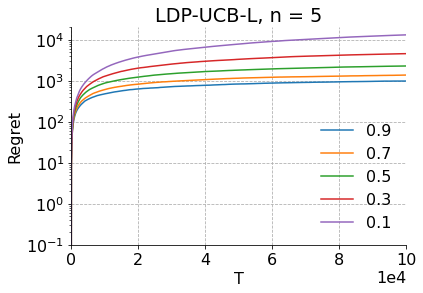

In [83]:
fig = plt.figure()
ax = fig.gca()
for i in range(len(epsilon_list)):
    label = epsilon_list[i]
    ax.plot(regrets_epsilon[i], label=label )

plt.yscale('log')
plt.xlabel("T")
plt.ylabel("Regret")
plt.title("LDP-UCB-L, n = 5")
plt.grid('True',linestyle = '--')
plt.axis([0, 100000, 0.1, 20000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams.update({'font.size': 16})
plt.ticklabel_format(style='sci', axis='x',scilimits=(4,4))
ax.legend(loc='lower right', frameon=False)
plt.savefig("graph.eps", bbox_inches = 'tight')
plt.show()

In [0]:
regrets_epsilon = np.loadtxt('/content/gdrive/My Drive/regrets_epsilon_B97531.csv', delimiter=',')

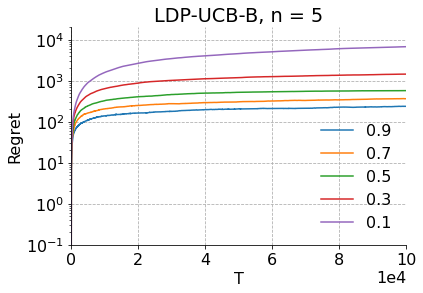

In [86]:
fig = plt.figure()
ax = fig.gca()
for i in range(len(epsilon_list)):
    label = epsilon_list[i]
    ax.plot(regrets_epsilon[i], label=label )

plt.yscale('log')
plt.xlabel("T")
plt.ylabel("Regret")
plt.title("LDP-UCB-B, n = 5")
plt.grid('True',linestyle = '--')
plt.axis([0, 100000, 0.1, 20000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams.update({'font.size': 16})
plt.ticklabel_format(style='sci', axis='x',scilimits=(4,4))
ax.legend(loc='lower right', frameon=False)
plt.savefig("graph.eps", bbox_inches = 'tight')
plt.show()

In [0]:
np.savetxt('/content/gdrive/My Drive/regrets_epsilon_L97531.csv', regrets_epsilon, delimiter=',')

In [54]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
